Training with **Sentinel-2 L2A** data (natural-looking images).

# 0. Setup

## 0.1. Libraries

In [ ]:
# Utilities
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning
import torch
from torch import nn, utils
from torchmetrics import classification

# Custom library
from library import nn_model, utilities, visualizations, preprocessing

# Device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)
print(f'Using device: {device}')

# Utilities
seed = 42
utilities.set_seed(seed)

Using device: cuda
Seed set to 42 for NumPy, Torch and Random for reproducibility.


## 0.2. Setting the path to the training data

We set the path to the tiles that have been created in the preprocessing notebook, `3_preprocessing.ipynb`.

In [2]:
base_input_dir = '/media/pablo/Shared files/data/'  # Adjust this path to your data directory containing the labelled dataset
input_labelled_dir = os.path.join(base_input_dir, 'Satellite_burned_area_dataset')  # Path to the original labelled dataset
tile_dir = os.path.join(base_input_dir, 'tiled_labelled_dataset')  # Path to the tiled dataset
sentinel_type = 2  # Sentinel-2 data

## 0.3. Notebook description

We train a multi-class segmentation model that assesses wildfire severity using satellite images **from Sentinel-2 L2A** (the "natural-looking" images). Additional steps applied during training:
- Randomly shuffle the tiles (done at the training stage).
- Apply data augmentation techniques to improve the robustness of the model. The authors implement the following transformations (we will do similar but different ones, this is just as reference): "*We applied the following transformations: rotation (up to 50° on both sides), shear (up to 20°), horizontal flip, and vertical flip, all of them with a probability of 50%.*"
- If computationally feasible, we will do cross-fold validation. Otherwise, we will just divide the data statically into training, validation and test. The authors use "*a 7-fold cross-validation approach [...]: 5 folds were used as a training set, 1 fold as a validation set, and 1 fold as a test set.*"
- Adjust the training hyperparameters: "*16GB. The training was performed using 50 epochs, the Adam optimizer with a learning rate of 0.0001 with no weight decay. The Dice loss was used for training. [...] We implemented an early stopping mechanism with patience of 5 epochs and tolerance of 0.01 on validation loss. The final evaluation is performed on the test set.*"

> The final goal is to train a model that estimates the severity of a wildfire using post-wildfire (1 month after) imagery, and then to run inference with the satellite images from wildfires in Catalunya in the last decade. Severity estimation will be done at the pixel level.

We are going to use the U-Net architecture:

![U-Net model](unet_diagram.jpg)

# 1. Preparing the data

## 1.1. Getting the image and masks paths

In [3]:
# Get all of the folders within the tiles directory
fire_folders = sorted([f for f in os.listdir(tile_dir) if os.path.isdir(os.path.join(tile_dir, f))])
# Print the first 5 folders
print("First 5 fire folders:")
print(fire_folders[:5])
# Print the total number of fire folders
print("Total number of fire folders:", len(fire_folders))

# Get the paths for the images and the labels
image_paths = []
label_paths = []
for fire_folder in fire_folders:
    print(f"Fire folder: {fire_folder}")
    images_path = os.path.join(tile_dir, fire_folder, 'images')
    labels_path = os.path.join(tile_dir, fire_folder, 'masks')
    if os.path.exists(images_path):
        image_paths.append(sorted([os.path.join(images_path, img) for img in os.listdir(images_path) if img.startswith(f'sentinel{sentinel_type}') and img.endswith('.tiff')]))
    else:
        print(f"Images path does not exist: {images_path}")
    if os.path.exists(labels_path):
        label_paths.append(sorted([os.path.join(labels_path, lbl) for lbl in os.listdir(labels_path) if lbl.endswith('.tiff')]))
    else:
        print(f"Labels path does not exist: {labels_path}")
# Print the first 5 image paths
print(f"First 5 image and label paths of the fire folder: {fire_folders[0]}")
print(image_paths[0][:5])  # The result is a list of lists, where each sublist contains the paths of images for a specific fire folder
print(label_paths[0][:5])  # The result is a list of lists, where each sublist contains the paths of labels for a specific fire folder

# Print the total number of lists in image_paths and label_paths (should be equal to the number of fire folders)
print("Total number of fire folders in image_paths:", len(image_paths))
print("Total number of fire folders in label_paths:", len(label_paths))

First 5 fire folders:
['EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector', 'EMSR207_02LOUSA_02GRADING_MAP_v2_vector', 'EMSR207_03PAMPILHOSADASERRA_02GRADING_MAP_v2_vector', 'EMSR207_04AVELAR_02GRADING_MAP_v2_vector', 'EMSR207_05PEDROGAOGRANDE_02GRADING_MAP_v2_vector']
Total number of fire folders: 73
Fire folder: EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector
Fire folder: EMSR207_02LOUSA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_03PAMPILHOSADASERRA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_04AVELAR_02GRADING_MAP_v2_vector
Fire folder: EMSR207_05PEDROGAOGRANDE_02GRADING_MAP_v2_vector
Fire folder: EMSR207_06MADEIRA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_07ALVAIAZERE_02GRADING_MAP_v2_vector
Fire folder: EMSR207_08CERNACHEDOBONJARDIM_02GRADING_MAP_v2_vector
Fire folder: EMSR207_10ORVALHO_02GRADING_MAP_v2_vector
Fire folder: EMSR209_01MOGUER_02GRADING_MAP_v2_vector
Fire folder: EMSR209_02MAZAGON_02GRADING_MAP_v2_vector
Fire folder: EMSR209_03LOSCABEZUDOS_02GRADING_MAP_v1_vecto

## 1.2. Loading the image and masks into tensors

We load the images and labels as `torch.Tensor` of dimensions $n \times d \times h \times w$, where:
- $n$: number of images (tiles)/masks.
- $d$: number of channels for the images/masks.
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.

We normalize each channel to $N[0,1]$ and set the data type as `torch.float32` (set to `torch.float16` for greater memory efficiency). Why we normalize image channels:

1. **Gradient stability**: Different channels may have vastly different value ranges, leading to unstable gradients
2. **Training speed**: Normalized inputs help the optimizer converge faster
3. **Weight initialization**: Most weight initialization schemes assume normalized inputs
4. **Activation functions**: Work optimally with inputs in specific ranges

In [4]:
# Flatten the lists of image and label paths
images_flat = [item for sublist in image_paths for item in sublist]
labels_flat = [item for sublist in label_paths for item in sublist]

# Read images and labels and stack them into a single tensor (reduce precision to float16 for greater efficiency)
images = torch.stack([utilities.read_tiff_to_torch(file_path = image, dtype=torch.float32, normalize=True, normalization_method='per_channel') for image in images_flat])
labels_raw = torch.stack([utilities.read_tiff_to_torch(file_path = label, dtype = torch.float32, normalize=True, normalization_method='255') for label in labels_flat])  # Masks are encoded in 0-255 range according to the paper

Now, let's check the array dimensions and display several image–label pairs to ensure that they are correctly aligned.

In [5]:
print('Size of the image tensor:', images.size())
print('Size of the label tensor:', labels_raw.size())

# Check if the number of images and labels are equal
if images.size(0) != labels_raw.size(0):
    raise ValueError('Number of images and labels do not match!')

Size of the image tensor: torch.Size([3230, 13, 256, 256])
Size of the label tensor: torch.Size([3230, 1, 256, 256])


i.e., in this case:

- $n$: we have 3,230 images and masks (3,374 images before removing those without coverage in the EDA notebook).
- $d$: number of channels for the images/masks. The images have 13 dimensions (bands B01-B12 from Sentinel-2 L2A plus the coverage -validity- mask https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html#available-bands-and-data).
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.

For simplicity, we will not be removing the coverage mask dimension as it will not affect training (all pixels without coverage were already removed in the EDA notebook, so the values are uniform).

## 1.3. Checking the alignment: displaying several image-label pairs

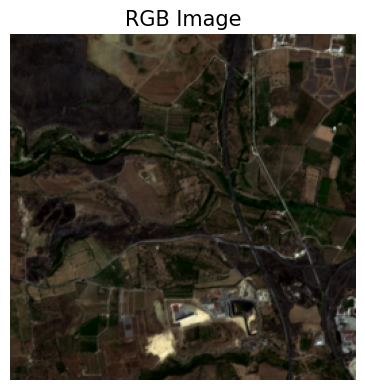

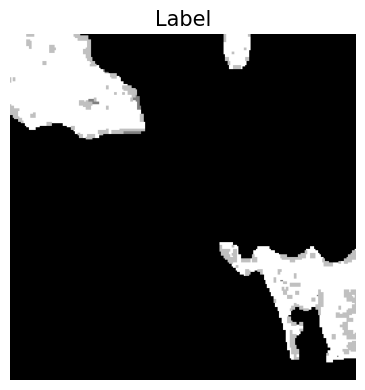

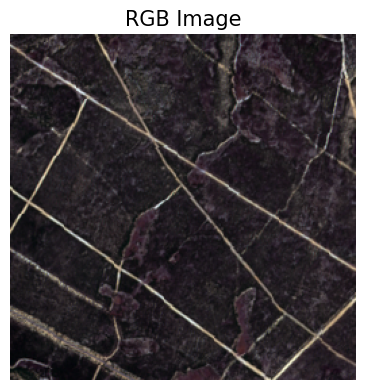

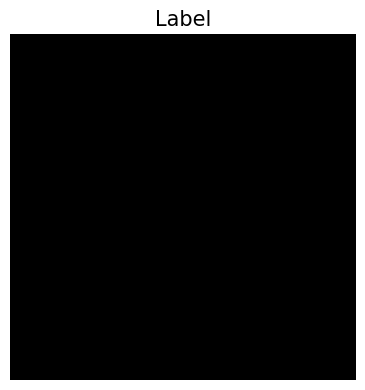

In [6]:
# Displays random images, labels and images
for i in torch.randint(0, len(images), (2,)):
  visualizations.display_image(image = images[i], title = 'RGB Image', rgb_bands=(3,2,1))  # RGB bands in Sentinel-2 are 3 (B04), 2 (B03), and 1 (B02)
  visualizations.display_image(image = labels_raw[i], title = 'Label')

Note that, in this case, **the brighter the label in the mask, the higher the severity of the fire (white if maximum severity)**. Areas affected by fires of lower severity are darker. 

## 1.4. Mapping the classes to integers 

In [ ]:
# Apply the mapping
labels = utilities.map_labels_to_classes_approximate(labels_raw)

del labels_raw  # Free up memory

In [9]:
# Print the unique values in the labels tensor to verify the mapping
print("Unique values in the labels tensor after mapping:", torch.unique(labels))

Unique values in the labels tensor after mapping: tensor([0, 1, 2, 3, 4])


## 1.5. Formatting the data as a `TensorDataset`

Useful documentation: [`torch.utils.data`](https://pytorch.org/docs/stable/data.html)

In [10]:
# Format the data as a TensorDataset
dataset = utils.data.TensorDataset(images, labels)  # Create a TensorDataset from the image and label tensors
print(len(dataset))

3230


## 1.6. Splitting data into train, validation and test

We split into 70% training data, 15% validation and 15% test.

In [11]:
# Split the dataset into training, validation and test sets
train_dataset, val_dataset, test_dataset = utils.data.random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(seed))

# Set batch size
batch_size = 64

# Set number of physical CPU cores (as int) to use for data loading
num_workers = os.cpu_count() // 2 if os.cpu_count() is not None else 0

# Create DataLoaders for each dataset
train_loader = utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle the training data to prevent learning order bias, overfitting and improve generalization
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

val_loader = utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Keep validation data in the same order for consistent evaluation
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

test_loader = utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Keep test data in the same order for consistent evaluation
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

# 2. Training and validation

## 2.1. Neural Network Architecture

![U-Net model](unet_diagram.jpg)

The basic structure of this network is the following:

1. **Input**: a tensor of shape $(N, D, H, W)$.
2. **Encode** down through five levels, doubling channels each time and halving spatial dimensions.
3. **Bottleneck**: deepest features at 128 channels.
4. **Decode** back up, halving channels and doubling spatial dimensions, while concatenating corresponding encoder features to preserve fine details.
5. **Output**: apply a 1×1 convolution → Sigmoid to produce a mask of shape $(N, 1, H, W)$ with values in (0,1).

All of the classes below initialize the parameters at each layer with `__init__` and then implement a `forward` method that defines the forward pass of the neural network, which "takes the input data and passes it through the layers of the network to produce the output. This method is executed whenever the model is called to make a prediction or to compute the loss during training" ([reference](https://discuss.pytorch.org/t/what-is-the-difference-init-and-forward-in-a-network-model/173907)).

### The double convolution

The two convolutional layers are included everywhere in the network, from the encoding to the decoding. For more information, check `DoubleConv` in the library `library`.

Useful sources:
- [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) - convolutional layer
- [`BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) - normalization layer
- [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) - non-linear activation function

### The encoder module (`Down`)

The class below represents one encoding step. For more information, check `Down` in the library `library`.

Useful sources:
- [`MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) - pooling layer

### The decoder module (`Up`)

This class represents one decoding step. It performs upsampling and concatenation with skip connection. For more information, check `Up` in the library `library`.

This class:

1. Upsamples via either bilinear interpolation or a learnable transposed convolution. See [`nn.Upsample`](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample)
2. Pads if the resulting feature-map is off by 1 pixel in height/width. See [`nn.functional.pad`](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad)
3. Concatenates with the corresponding encoder feature-map along the channel dimension (the “skip connection”). See [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html)
4. Uses `DoubleConv` to fuse and refine these combined features.

### Final 1 $\times$ 1 convolution

This convolution reduces the channels from whatever the last decoder output is (in the diagram, 8) down to the desired number of classes (1 for binary mask, as in this case - 0 for no building and 1 for building). For more information, check `OutConv` in the library `library`.

### Putting all together in `UNet`

This class uses the constructions made above, and replicates the structure of the neural network in the diagram. For more information, check `UNet` in the library `library`.

Note that the output layer returns the logits, not probabilities, for compatibility with the loss function.

## 2.2. Training setup

### Model initialization

In [ ]:
# Set the parameters for the U-Net model
n_channels = images.size()[1]  # Number of input channels (13 for Sentinel-2 data)
n_classes = 5  # Number of output channels (5 classes: 0: not burned, 1-4: burned area with different severity levels, from lower to higher severity)
base_filters = 8  # Number of filters in the first layer (check diagram)
dropout_p = 0.1  # Dropout probability for regularization
bilinear = False  # Use bilinear interpolation for upsampling (True) or transposed convolution (False)

# Initialize the model
model = nn_model.UNet(
    n_channels=n_channels,
    n_classes=n_classes, 
    base_filters=base_filters,
    dropout_p=dropout_p,
    bilinear=bilinear
)
model = model.to(device)  # Move the model to the specified device (GPU or CPU)
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(13, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout2d(p=0.1, inplace=False)
    )
  )
  (down1): Down(
    (pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)

### Loss function (addresses class imbalance)

Simple weights where we weight more the less common classes, and underweight the most common ones.

In [13]:
# Calculate class frequencies and weights
def calculate_class_weights(labels_tensor, n_classes=5):
    """
    Calculate class weights for handling class imbalance
    """
    # Flatten the labels tensor to count occurrences
    labels_flat = labels_tensor.flatten()
    
    # Count occurrences of each class
    class_counts = torch.bincount(labels_flat, minlength=n_classes)
    
    # Calculate total number of pixels
    total_pixels = labels_flat.numel()
    
    # Calculate class frequencies
    class_frequencies = class_counts.float() / total_pixels
    
    # Calculate inverse frequency weights (more weight for less frequent classes)
    class_weights = 1.0 / (class_frequencies + 1e-6)  # Add small epsilon to avoid division by zero
    
    # Normalize weights so they sum to n_classes (optional, helps with stability)
    class_weights = class_weights / class_weights.sum() * n_classes
    
    return class_weights, class_counts, class_frequencies

# Calculate class weights
class_weights, class_counts, class_frequencies = calculate_class_weights(labels, n_classes=5)

# Print class statistics
print("Class distribution:")
for i in range(5):
    print(f"Class {i}: {class_counts[i].item():,} pixels ({class_frequencies[i].item():.4f})")

print(f"\nClass weights: {class_weights}")

Class distribution:
Class 0: 173,585,187 pixels (0.8200)
Class 1: 21,563,732 pixels (0.1019)
Class 2: 5,325,971 pixels (0.0252)
Class 3: 5,598,256 pixels (0.0264)
Class 4: 5,608,134 pixels (0.0265)

Class weights: tensor([0.0483, 0.3885, 1.5730, 1.4965, 1.4938])


In [14]:
# Create the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

More information about the [`CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) class. Relevant things to consider:
- "Useful when training a classification problem with *C* classes".
- "The input is expected to contain the unnormalized logits for each class".

### Optimization algorithm

In [ ]:
# We set the parameters of the optimizer like the authors of the paper 
# (see section 0.3 of the notebook)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-4,  # Learning rate
    weight_decay=0  # Weight decay (L2 regularization). 1e-5 is a common value, but we set it to 0 to match the paper's settings
)

References: [`torch.optim`](https://pytorch.org/docs/stable/optim.html)

## 2.3. Train-validation routine

[Basic guide](https://machinelearningmastery.com/creating-a-training-loop-for-pytorch-models/?utm_source=chatgpt.com) for creating a training loop.

This training routine includes (for more information, check out `train_model` in `library`):

1. Progress tracking with tqdm progress bars for both training and validation steps
2. Loss and IoU calculation for both training and validation sets. The IoU (Intersection over Union) metric is appropriate for segmentation tasks as it measures the overlap between the predicted segmentation and the ground truth.
3. Early stopping that monitors validation loss and stops training when no improvement is seen for a certain number of epochs
4. Best model saving that saves the model parameters (from the initialization in 5), weights with the lowest validation loss
5. Visualization of metrics to monitor the training process and check for overfitting

### Estimating the model weights

In [16]:
# Set training parameters, again, as in the paper (see section 0.3 of the notebook)
num_epochs = 200  # Maximum number of epochs to train
patience = 5  # Number of epochs with no improvement after which training will be stopped
delta = 0.001  # Tolerance (minimum change in validation loss to qualify as improvement)

# Train the model
model, history, best_val_loss = nn_model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_classes=5,
    num_epochs=num_epochs,
    patience=patience,
    delta=delta
)

Epoch 1/200
--------------------------------------------------


Val Loss: 1.5935: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]

Training Loss: 1.6335, IoU: 0.0391
Validation Loss: 1.5983, IoU: 0.0382
Validation loss improved from inf to 1.5983

Epoch 2/200
--------------------------------------------------



Val Loss: 1.5942: 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

Training Loss: 1.6076, IoU: 0.0418
Validation Loss: 1.5782, IoU: 0.0437
Validation loss improved from 1.5983 to 1.5782

Epoch 3/200
--------------------------------------------------



Val Loss: 1.5742: 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]

Training Loss: 1.5779, IoU: 0.0458
Validation Loss: 1.5618, IoU: 0.0453
Validation loss improved from 1.5782 to 1.5618

Epoch 4/200
--------------------------------------------------



Val Loss: 1.5601: 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

Training Loss: 1.5615, IoU: 0.0482
Validation Loss: 1.5485, IoU: 0.0487
Validation loss improved from 1.5618 to 1.5485

Epoch 5/200
--------------------------------------------------



Val Loss: 1.5455: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]

Training Loss: 1.5488, IoU: 0.0523
Validation Loss: 1.5394, IoU: 0.0558
Validation loss improved from 1.5485 to 1.5394

Epoch 6/200
--------------------------------------------------



Val Loss: 1.5296: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]

Training Loss: 1.5333, IoU: 0.0575
Validation Loss: 1.5238, IoU: 0.0579
Validation loss improved from 1.5394 to 1.5238

Epoch 7/200
--------------------------------------------------



Val Loss: 1.5062: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

Training Loss: 1.5146, IoU: 0.0635
Validation Loss: 1.5111, IoU: 0.0650
Validation loss improved from 1.5238 to 1.5111

Epoch 8/200
--------------------------------------------------



Val Loss: 1.4865: 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]

Training Loss: 1.5049, IoU: 0.0663
Validation Loss: 1.4987, IoU: 0.0698
Validation loss improved from 1.5111 to 1.4987

Epoch 9/200
--------------------------------------------------



Val Loss: 1.4731: 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]

Training Loss: 1.4773, IoU: 0.0736
Validation Loss: 1.4899, IoU: 0.0726
Validation loss improved from 1.4987 to 1.4899

Epoch 10/200
--------------------------------------------------



Val Loss: 1.4463: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

Training Loss: 1.4898, IoU: 0.0744
Validation Loss: 1.4766, IoU: 0.0819
Validation loss improved from 1.4899 to 1.4766

Epoch 11/200
--------------------------------------------------



Val Loss: 1.4401: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]

Training Loss: 1.4773, IoU: 0.0768
Validation Loss: 1.4708, IoU: 0.0775
Validation loss improved from 1.4766 to 1.4708

Epoch 12/200
--------------------------------------------------



Val Loss: 1.4282: 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

Training Loss: 1.4691, IoU: 0.0774
Validation Loss: 1.4650, IoU: 0.0805
Validation loss improved from 1.4708 to 1.4650

Epoch 13/200
--------------------------------------------------



Val Loss: 1.4106: 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]

Training Loss: 1.4539, IoU: 0.0793
Validation Loss: 1.4556, IoU: 0.0848
Validation loss improved from 1.4650 to 1.4556

Epoch 14/200
--------------------------------------------------



Val Loss: 1.3919: 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]

Training Loss: 1.4464, IoU: 0.0843
Validation Loss: 1.4381, IoU: 0.0897
Validation loss improved from 1.4556 to 1.4381

Epoch 15/200
--------------------------------------------------



Val Loss: 1.3593: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

Training Loss: 1.4234, IoU: 0.0913
Validation Loss: 1.4108, IoU: 0.0942
Validation loss improved from 1.4381 to 1.4108

Epoch 16/200
--------------------------------------------------



Val Loss: 1.3427: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]

Training Loss: 1.4097, IoU: 0.0936
Validation Loss: 1.3835, IoU: 0.1032
Validation loss improved from 1.4108 to 1.3835

Epoch 17/200
--------------------------------------------------



Val Loss: 1.3097: 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]

Training Loss: 1.3859, IoU: 0.0971
Validation Loss: 1.3658, IoU: 0.0981
Validation loss improved from 1.3835 to 1.3658

Epoch 18/200
--------------------------------------------------



Val Loss: 1.3075: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]

Training Loss: 1.3822, IoU: 0.1061
Validation Loss: 1.3531, IoU: 0.1097
Validation loss improved from 1.3658 to 1.3531

Epoch 19/200
--------------------------------------------------



Val Loss: 1.2923: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

Training Loss: 1.3882, IoU: 0.1024
Validation Loss: 1.3386, IoU: 0.1172
Validation loss improved from 1.3531 to 1.3386

Epoch 20/200
--------------------------------------------------



Val Loss: 1.2745: 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]

Training Loss: 1.3487, IoU: 0.1101
Validation Loss: 1.3262, IoU: 0.1200
Validation loss improved from 1.3386 to 1.3262

Epoch 21/200
--------------------------------------------------



Val Loss: 1.2890: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

Training Loss: 1.3460, IoU: 0.1103
Validation Loss: 1.3412, IoU: 0.1238
No improvement in validation loss for 1 epochs

Epoch 22/200
--------------------------------------------------



Val Loss: 1.2562: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]

Training Loss: 1.3365, IoU: 0.1096
Validation Loss: 1.3115, IoU: 0.1186
Validation loss improved from 1.3262 to 1.3115

Epoch 23/200
--------------------------------------------------



Val Loss: 1.2298: 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]

Training Loss: 1.3396, IoU: 0.1063
Validation Loss: 1.3007, IoU: 0.1081
Validation loss improved from 1.3115 to 1.3007

Epoch 24/200
--------------------------------------------------



Val Loss: 1.2575: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]

Training Loss: 1.3349, IoU: 0.1104
Validation Loss: 1.3108, IoU: 0.1255
No improvement in validation loss for 1 epochs

Epoch 25/200
--------------------------------------------------



Val Loss: 1.2190: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.3280, IoU: 0.1048
Validation Loss: 1.2841, IoU: 0.1088
Validation loss improved from 1.3007 to 1.2841

Epoch 26/200
--------------------------------------------------



Val Loss: 1.2084: 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]

Training Loss: 1.3212, IoU: 0.1095
Validation Loss: 1.2723, IoU: 0.1152
Validation loss improved from 1.2841 to 1.2723

Epoch 27/200
--------------------------------------------------



Val Loss: 1.2300: 100%|██████████| 8/8 [00:01<00:00,  5.20it/s]

Training Loss: 1.3164, IoU: 0.1088
Validation Loss: 1.2811, IoU: 0.1185
No improvement in validation loss for 1 epochs

Epoch 28/200
--------------------------------------------------



Val Loss: 1.1837: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.3167, IoU: 0.1067
Validation Loss: 1.2625, IoU: 0.1103
Validation loss improved from 1.2723 to 1.2625

Epoch 29/200
--------------------------------------------------



Val Loss: 1.2010: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]

Training Loss: 1.2932, IoU: 0.1117
Validation Loss: 1.2626, IoU: 0.1174
No improvement in validation loss for 1 epochs

Epoch 30/200
--------------------------------------------------



Val Loss: 1.1838: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]

Training Loss: 1.2799, IoU: 0.1126
Validation Loss: 1.2510, IoU: 0.1211
Validation loss improved from 1.2625 to 1.2510

Epoch 31/200
--------------------------------------------------



Val Loss: 1.1903: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.2974, IoU: 0.1052
Validation Loss: 1.2477, IoU: 0.1205
Validation loss improved from 1.2510 to 1.2477

Epoch 32/200
--------------------------------------------------



Val Loss: 1.1624: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.2835, IoU: 0.1135
Validation Loss: 1.2398, IoU: 0.1176
Validation loss improved from 1.2477 to 1.2398

Epoch 33/200
--------------------------------------------------



Val Loss: 1.1670: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]

Training Loss: 1.2768, IoU: 0.1134
Validation Loss: 1.2333, IoU: 0.1285
Validation loss improved from 1.2398 to 1.2333

Epoch 34/200
--------------------------------------------------



Val Loss: 1.1488: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]

Training Loss: 1.2675, IoU: 0.1175
Validation Loss: 1.2272, IoU: 0.1273
Validation loss improved from 1.2333 to 1.2272

Epoch 35/200
--------------------------------------------------



Val Loss: 1.1653: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

Training Loss: 1.2702, IoU: 0.1144
Validation Loss: 1.2307, IoU: 0.1229
No improvement in validation loss for 1 epochs

Epoch 36/200
--------------------------------------------------



Val Loss: 1.1354: 100%|██████████| 8/8 [00:01<00:00,  5.20it/s]

Training Loss: 1.2705, IoU: 0.1203
Validation Loss: 1.2055, IoU: 0.1203
Validation loss improved from 1.2272 to 1.2055

Epoch 37/200
--------------------------------------------------



Val Loss: 1.1492: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

Training Loss: 1.2590, IoU: 0.1141
Validation Loss: 1.2127, IoU: 0.1313
No improvement in validation loss for 1 epochs

Epoch 38/200
--------------------------------------------------



Val Loss: 1.1468: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]

Training Loss: 1.2550, IoU: 0.1201
Validation Loss: 1.2085, IoU: 0.1344
No improvement in validation loss for 2 epochs

Epoch 39/200
--------------------------------------------------



Val Loss: 1.1403: 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]

Training Loss: 1.2669, IoU: 0.1174
Validation Loss: 1.2086, IoU: 0.1273
No improvement in validation loss for 3 epochs

Epoch 40/200
--------------------------------------------------



Val Loss: 1.1300: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

Training Loss: 1.2347, IoU: 0.1233
Validation Loss: 1.1988, IoU: 0.1237
Validation loss improved from 1.2055 to 1.1988

Epoch 41/200
--------------------------------------------------



Val Loss: 1.1248: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]

Training Loss: 1.2446, IoU: 0.1194
Validation Loss: 1.1963, IoU: 0.1252
Validation loss improved from 1.1988 to 1.1963

Epoch 42/200
--------------------------------------------------



Val Loss: 1.0927: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]

Training Loss: 1.2425, IoU: 0.1235
Validation Loss: 1.1784, IoU: 0.1278
Validation loss improved from 1.1963 to 1.1784

Epoch 43/200
--------------------------------------------------



Val Loss: 1.1003: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

Training Loss: 1.2408, IoU: 0.1157
Validation Loss: 1.1802, IoU: 0.1361
No improvement in validation loss for 1 epochs

Epoch 44/200
--------------------------------------------------



Val Loss: 1.1093: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.2296, IoU: 0.1256
Validation Loss: 1.1837, IoU: 0.1304
No improvement in validation loss for 2 epochs

Epoch 45/200
--------------------------------------------------



Val Loss: 1.0915: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]

Training Loss: 1.2155, IoU: 0.1288
Validation Loss: 1.1734, IoU: 0.1409
Validation loss improved from 1.1784 to 1.1734

Epoch 46/200
--------------------------------------------------



Val Loss: 1.0876: 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]

Training Loss: 1.2153, IoU: 0.1303
Validation Loss: 1.1676, IoU: 0.1378
Validation loss improved from 1.1734 to 1.1676

Epoch 47/200
--------------------------------------------------



Val Loss: 1.0871: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]

Training Loss: 1.1954, IoU: 0.1346
Validation Loss: 1.1713, IoU: 0.1465
No improvement in validation loss for 1 epochs

Epoch 48/200
--------------------------------------------------



Val Loss: 1.0753: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]

Training Loss: 1.2120, IoU: 0.1290
Validation Loss: 1.1612, IoU: 0.1391
Validation loss improved from 1.1676 to 1.1612

Epoch 49/200
--------------------------------------------------



Val Loss: 1.0687: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]

Training Loss: 1.2043, IoU: 0.1367
Validation Loss: 1.1545, IoU: 0.1480
Validation loss improved from 1.1612 to 1.1545

Epoch 50/200
--------------------------------------------------



Val Loss: 1.0558: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]

Training Loss: 1.1952, IoU: 0.1427
Validation Loss: 1.1440, IoU: 0.1410
Validation loss improved from 1.1545 to 1.1440

Epoch 51/200
--------------------------------------------------



Val Loss: 1.0680: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.1917, IoU: 0.1418
Validation Loss: 1.1515, IoU: 0.1606
No improvement in validation loss for 1 epochs

Epoch 52/200
--------------------------------------------------



Val Loss: 1.0484: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]

Training Loss: 1.2153, IoU: 0.1394
Validation Loss: 1.1434, IoU: 0.1494
No improvement in validation loss for 2 epochs

Epoch 53/200
--------------------------------------------------



Val Loss: 1.0805: 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]

Training Loss: 1.1998, IoU: 0.1440
Validation Loss: 1.1445, IoU: 0.1636
No improvement in validation loss for 3 epochs

Epoch 54/200
--------------------------------------------------



Val Loss: 1.0638: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

Training Loss: 1.1908, IoU: 0.1485
Validation Loss: 1.1497, IoU: 0.1738
No improvement in validation loss for 4 epochs

Epoch 55/200
--------------------------------------------------



Val Loss: 1.0416: 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

Training Loss: 1.1863, IoU: 0.1595
Validation Loss: 1.1385, IoU: 0.1752
Validation loss improved from 1.1440 to 1.1385

Epoch 56/200
--------------------------------------------------



Val Loss: 1.0503: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

Training Loss: 1.1871, IoU: 0.1577
Validation Loss: 1.1388, IoU: 0.1845
No improvement in validation loss for 1 epochs

Epoch 57/200
--------------------------------------------------



Val Loss: 1.0438: 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]

Training Loss: 1.1717, IoU: 0.1681
Validation Loss: 1.1321, IoU: 0.1785
Validation loss improved from 1.1385 to 1.1321

Epoch 58/200
--------------------------------------------------



Val Loss: 1.0351: 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

Training Loss: 1.1737, IoU: 0.1652
Validation Loss: 1.1193, IoU: 0.1807
Validation loss improved from 1.1321 to 1.1193

Epoch 59/200
--------------------------------------------------



Val Loss: 1.0235: 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

Training Loss: 1.1609, IoU: 0.1717
Validation Loss: 1.1206, IoU: 0.1771
No improvement in validation loss for 1 epochs

Epoch 60/200
--------------------------------------------------



Val Loss: 1.0543: 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]

Training Loss: 1.1583, IoU: 0.1765
Validation Loss: 1.1334, IoU: 0.1910
No improvement in validation loss for 2 epochs

Epoch 61/200
--------------------------------------------------



Val Loss: 1.0375: 100%|██████████| 8/8 [00:01<00:00,  4.85it/s]

Training Loss: 1.1703, IoU: 0.1810
Validation Loss: 1.1168, IoU: 0.1982
Validation loss improved from 1.1193 to 1.1168

Epoch 62/200
--------------------------------------------------



Val Loss: 1.0377: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

Training Loss: 1.1676, IoU: 0.1812
Validation Loss: 1.1101, IoU: 0.1944
Validation loss improved from 1.1168 to 1.1101

Epoch 63/200
--------------------------------------------------



Val Loss: 1.0197: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

Training Loss: 1.1721, IoU: 0.1820
Validation Loss: 1.1135, IoU: 0.1998
No improvement in validation loss for 1 epochs

Epoch 64/200
--------------------------------------------------



Val Loss: 0.9954: 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]

Training Loss: 1.1629, IoU: 0.1898
Validation Loss: 1.1040, IoU: 0.1999
Validation loss improved from 1.1101 to 1.1040

Epoch 65/200
--------------------------------------------------



Val Loss: 1.0132: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

Training Loss: 1.1523, IoU: 0.1983
Validation Loss: 1.0928, IoU: 0.2179
Validation loss improved from 1.1040 to 1.0928

Epoch 66/200
--------------------------------------------------



Val Loss: 1.0229: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

Training Loss: 1.1345, IoU: 0.2039
Validation Loss: 1.1014, IoU: 0.2303
No improvement in validation loss for 1 epochs

Epoch 67/200
--------------------------------------------------



Val Loss: 1.0253: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]

Training Loss: 1.1629, IoU: 0.2056
Validation Loss: 1.1041, IoU: 0.2085
No improvement in validation loss for 2 epochs

Epoch 68/200
--------------------------------------------------



Val Loss: 1.0225: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]

Training Loss: 1.1414, IoU: 0.2158
Validation Loss: 1.0970, IoU: 0.2236
No improvement in validation loss for 3 epochs

Epoch 69/200
--------------------------------------------------



Val Loss: 0.9923: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.1486, IoU: 0.2121
Validation Loss: 1.0865, IoU: 0.2256
Validation loss improved from 1.0928 to 1.0865

Epoch 70/200
--------------------------------------------------



Val Loss: 0.9825: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]

Training Loss: 1.1570, IoU: 0.2068
Validation Loss: 1.0877, IoU: 0.2310
No improvement in validation loss for 1 epochs

Epoch 71/200
--------------------------------------------------



Val Loss: 0.9745: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

Training Loss: 1.1279, IoU: 0.2294
Validation Loss: 1.0845, IoU: 0.2406
Validation loss improved from 1.0865 to 1.0845

Epoch 72/200
--------------------------------------------------



Val Loss: 0.9749: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]

Training Loss: 1.1520, IoU: 0.2220
Validation Loss: 1.0787, IoU: 0.2435
Validation loss improved from 1.0845 to 1.0787

Epoch 73/200
--------------------------------------------------



Val Loss: 0.9705: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

Training Loss: 1.1392, IoU: 0.2274
Validation Loss: 1.0796, IoU: 0.2394
No improvement in validation loss for 1 epochs

Epoch 74/200
--------------------------------------------------



Val Loss: 0.9792: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

Training Loss: 1.1482, IoU: 0.2206
Validation Loss: 1.0767, IoU: 0.2464
Validation loss improved from 1.0787 to 1.0767

Epoch 75/200
--------------------------------------------------



Val Loss: 0.9693: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]

Training Loss: 1.1301, IoU: 0.2301
Validation Loss: 1.0619, IoU: 0.2458
Validation loss improved from 1.0767 to 1.0619

Epoch 76/200
--------------------------------------------------



Val Loss: 0.9805: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]

Training Loss: 1.1120, IoU: 0.2465
Validation Loss: 1.0781, IoU: 0.2563
No improvement in validation loss for 1 epochs

Epoch 77/200
--------------------------------------------------



Val Loss: 0.9772: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]

Training Loss: 1.1211, IoU: 0.2409
Validation Loss: 1.0782, IoU: 0.2403
No improvement in validation loss for 2 epochs

Epoch 78/200
--------------------------------------------------



Val Loss: 0.9403: 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]

Training Loss: 1.1253, IoU: 0.2390
Validation Loss: 1.0679, IoU: 0.2462
No improvement in validation loss for 3 epochs

Epoch 79/200
--------------------------------------------------



Val Loss: 0.9741: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.1023, IoU: 0.2558
Validation Loss: 1.0562, IoU: 0.2700
Validation loss improved from 1.0619 to 1.0562

Epoch 80/200
--------------------------------------------------



Val Loss: 0.9802: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]

Training Loss: 1.1138, IoU: 0.2486
Validation Loss: 1.0724, IoU: 0.2656
No improvement in validation loss for 1 epochs

Epoch 81/200
--------------------------------------------------



Val Loss: 0.9195: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

Training Loss: 1.1107, IoU: 0.2477
Validation Loss: 1.0480, IoU: 0.2585
Validation loss improved from 1.0562 to 1.0480

Epoch 82/200
--------------------------------------------------



Val Loss: 0.9389: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.1019, IoU: 0.2568
Validation Loss: 1.0420, IoU: 0.2614
Validation loss improved from 1.0480 to 1.0420

Epoch 83/200
--------------------------------------------------



Val Loss: 0.9244: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.1122, IoU: 0.2489
Validation Loss: 1.0412, IoU: 0.2527
No improvement in validation loss for 1 epochs

Epoch 84/200
--------------------------------------------------



Val Loss: 0.9330: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

Training Loss: 1.0927, IoU: 0.2643
Validation Loss: 1.0415, IoU: 0.2913
No improvement in validation loss for 2 epochs

Epoch 85/200
--------------------------------------------------



Val Loss: 0.9156: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

Training Loss: 1.1101, IoU: 0.2549
Validation Loss: 1.0606, IoU: 0.2550
No improvement in validation loss for 3 epochs

Epoch 86/200
--------------------------------------------------



Val Loss: 0.9585: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

Training Loss: 1.0913, IoU: 0.2683
Validation Loss: 1.0457, IoU: 0.2800
No improvement in validation loss for 4 epochs

Epoch 87/200
--------------------------------------------------



Val Loss: 0.9249: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]

Training Loss: 1.0840, IoU: 0.2618
Validation Loss: 1.0399, IoU: 0.2678
Validation loss improved from 1.0420 to 1.0399

Epoch 88/200
--------------------------------------------------



Val Loss: 0.9108: 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]

Training Loss: 1.1187, IoU: 0.2501
Validation Loss: 1.0317, IoU: 0.2753
Validation loss improved from 1.0399 to 1.0317

Epoch 89/200
--------------------------------------------------



Val Loss: 0.9201: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]

Training Loss: 1.0937, IoU: 0.2585
Validation Loss: 1.0278, IoU: 0.3063
Validation loss improved from 1.0317 to 1.0278

Epoch 90/200
--------------------------------------------------



Val Loss: 0.9331: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]

Training Loss: 1.0759, IoU: 0.2619
Validation Loss: 1.0228, IoU: 0.2797
Validation loss improved from 1.0278 to 1.0228

Epoch 91/200
--------------------------------------------------



Val Loss: 0.9304: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]

Training Loss: 1.0996, IoU: 0.2578
Validation Loss: 1.0237, IoU: 0.2870
No improvement in validation loss for 1 epochs

Epoch 92/200
--------------------------------------------------



Val Loss: 0.9440: 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]

Training Loss: 1.0748, IoU: 0.2715
Validation Loss: 1.0149, IoU: 0.2871
Validation loss improved from 1.0228 to 1.0149

Epoch 93/200
--------------------------------------------------



Val Loss: 0.8926: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]

Training Loss: 1.0677, IoU: 0.2800
Validation Loss: 1.0101, IoU: 0.2957
Validation loss improved from 1.0149 to 1.0101

Epoch 94/200
--------------------------------------------------



Val Loss: 0.9373: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

Training Loss: 1.0908, IoU: 0.2709
Validation Loss: 1.0398, IoU: 0.3181
No improvement in validation loss for 1 epochs

Epoch 95/200
--------------------------------------------------



Val Loss: 0.8953: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

Training Loss: 1.0732, IoU: 0.2678
Validation Loss: 1.0143, IoU: 0.2859
No improvement in validation loss for 2 epochs

Epoch 96/200
--------------------------------------------------



Val Loss: 0.9210: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

Training Loss: 1.0759, IoU: 0.2731
Validation Loss: 1.0168, IoU: 0.3067
No improvement in validation loss for 3 epochs

Epoch 97/200
--------------------------------------------------



Val Loss: 0.9044: 100%|██████████| 8/8 [00:01<00:00,  5.20it/s]

Training Loss: 1.0824, IoU: 0.2723
Validation Loss: 1.0057, IoU: 0.2797
Validation loss improved from 1.0101 to 1.0057

Epoch 98/200
--------------------------------------------------



Val Loss: 0.9097: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]

Training Loss: 1.0656, IoU: 0.2716
Validation Loss: 1.0134, IoU: 0.2926
No improvement in validation loss for 1 epochs

Epoch 99/200
--------------------------------------------------



Val Loss: 0.9006: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.0707, IoU: 0.2684
Validation Loss: 1.0010, IoU: 0.2938
Validation loss improved from 1.0057 to 1.0010

Epoch 100/200
--------------------------------------------------



Val Loss: 0.8970: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]

Training Loss: 1.0467, IoU: 0.2843
Validation Loss: 0.9983, IoU: 0.2898
Validation loss improved from 1.0010 to 0.9983

Epoch 101/200
--------------------------------------------------



Val Loss: 0.9232: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]

Training Loss: 1.0468, IoU: 0.2850
Validation Loss: 1.0097, IoU: 0.3020
No improvement in validation loss for 1 epochs

Epoch 102/200
--------------------------------------------------



Val Loss: 0.8871: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

Training Loss: 1.0751, IoU: 0.2708
Validation Loss: 1.0108, IoU: 0.3015
No improvement in validation loss for 2 epochs

Epoch 103/200
--------------------------------------------------



Val Loss: 0.8978: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]

Training Loss: 1.0528, IoU: 0.2797
Validation Loss: 1.0048, IoU: 0.3065
No improvement in validation loss for 3 epochs

Epoch 104/200
--------------------------------------------------



Val Loss: 0.8950: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]

Training Loss: 1.0325, IoU: 0.2887
Validation Loss: 1.0030, IoU: 0.3028
No improvement in validation loss for 4 epochs

Epoch 105/200
--------------------------------------------------



Val Loss: 0.8890: 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]

Training Loss: 1.0464, IoU: 0.2799
Validation Loss: 0.9959, IoU: 0.2749
Validation loss improved from 0.9983 to 0.9959

Epoch 106/200
--------------------------------------------------



Val Loss: 0.9137: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.0352, IoU: 0.2940
Validation Loss: 0.9917, IoU: 0.3190
Validation loss improved from 0.9959 to 0.9917

Epoch 107/200
--------------------------------------------------



Val Loss: 0.8779: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

Training Loss: 1.0315, IoU: 0.2953
Validation Loss: 0.9915, IoU: 0.3198
No improvement in validation loss for 1 epochs

Epoch 108/200
--------------------------------------------------



Val Loss: 0.8554: 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]

Training Loss: 1.0382, IoU: 0.2879
Validation Loss: 0.9786, IoU: 0.2894
Validation loss improved from 0.9917 to 0.9786

Epoch 109/200
--------------------------------------------------



Val Loss: 0.8986: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

Training Loss: 1.0403, IoU: 0.2911
Validation Loss: 1.0024, IoU: 0.3097
No improvement in validation loss for 1 epochs

Epoch 110/200
--------------------------------------------------



Val Loss: 0.8689: 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]

Training Loss: 1.0425, IoU: 0.2866
Validation Loss: 0.9739, IoU: 0.3207
Validation loss improved from 0.9786 to 0.9739

Epoch 111/200
--------------------------------------------------



Val Loss: 0.8668: 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

Training Loss: 1.0294, IoU: 0.2897
Validation Loss: 0.9868, IoU: 0.3225
No improvement in validation loss for 1 epochs

Epoch 112/200
--------------------------------------------------



Val Loss: 0.8721: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

Training Loss: 1.0219, IoU: 0.3003
Validation Loss: 0.9741, IoU: 0.2914
No improvement in validation loss for 2 epochs

Epoch 113/200
--------------------------------------------------



Val Loss: 0.8747: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]

Training Loss: 1.0247, IoU: 0.2910
Validation Loss: 0.9700, IoU: 0.3074
Validation loss improved from 0.9739 to 0.9700

Epoch 114/200
--------------------------------------------------



Val Loss: 0.8768: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

Training Loss: 1.0365, IoU: 0.2926
Validation Loss: 0.9724, IoU: 0.3072
No improvement in validation loss for 1 epochs

Epoch 115/200
--------------------------------------------------



Val Loss: 0.8882: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Training Loss: 1.0449, IoU: 0.2890
Validation Loss: 0.9605, IoU: 0.3276
Validation loss improved from 0.9700 to 0.9605

Epoch 116/200
--------------------------------------------------



Val Loss: 0.9018: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]

Training Loss: 1.0104, IoU: 0.3042
Validation Loss: 0.9757, IoU: 0.3362
No improvement in validation loss for 1 epochs

Epoch 117/200
--------------------------------------------------



Val Loss: 0.8625: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

Training Loss: 1.0220, IoU: 0.2927
Validation Loss: 0.9641, IoU: 0.2988
No improvement in validation loss for 2 epochs

Epoch 118/200
--------------------------------------------------



Val Loss: 0.8769: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

Training Loss: 1.0079, IoU: 0.3015
Validation Loss: 0.9645, IoU: 0.3029
No improvement in validation loss for 3 epochs

Epoch 119/200
--------------------------------------------------



Val Loss: 0.8768: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]

Training Loss: 0.9994, IoU: 0.3122
Validation Loss: 0.9572, IoU: 0.3134
Validation loss improved from 0.9605 to 0.9572

Epoch 120/200
--------------------------------------------------



Val Loss: 0.9075: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]

Training Loss: 1.0045, IoU: 0.3071
Validation Loss: 0.9628, IoU: 0.3144
No improvement in validation loss for 1 epochs

Epoch 121/200
--------------------------------------------------



Val Loss: 0.8703: 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]

Training Loss: 1.0206, IoU: 0.3013
Validation Loss: 0.9642, IoU: 0.3337
No improvement in validation loss for 2 epochs

Epoch 122/200
--------------------------------------------------



Val Loss: 0.8501: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]

Training Loss: 0.9819, IoU: 0.3109
Validation Loss: 0.9516, IoU: 0.3286
Validation loss improved from 0.9572 to 0.9516

Epoch 123/200
--------------------------------------------------



Val Loss: 0.8557: 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]

Training Loss: 1.0188, IoU: 0.3021
Validation Loss: 0.9465, IoU: 0.3229
Validation loss improved from 0.9516 to 0.9465

Epoch 124/200
--------------------------------------------------



Val Loss: 0.8450: 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]

Training Loss: 0.9883, IoU: 0.3185
Validation Loss: 0.9421, IoU: 0.3169
Validation loss improved from 0.9465 to 0.9421

Epoch 125/200
--------------------------------------------------



Val Loss: 0.8617: 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

Training Loss: 1.0019, IoU: 0.3143
Validation Loss: 0.9426, IoU: 0.3297
No improvement in validation loss for 1 epochs

Epoch 126/200
--------------------------------------------------



Val Loss: 0.8620: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

Training Loss: 1.0116, IoU: 0.3109
Validation Loss: 0.9411, IoU: 0.3091
Validation loss improved from 0.9421 to 0.9411

Epoch 127/200
--------------------------------------------------



Val Loss: 0.8798: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]

Training Loss: 0.9892, IoU: 0.3261
Validation Loss: 0.9575, IoU: 0.3191
No improvement in validation loss for 1 epochs

Epoch 128/200
--------------------------------------------------



Val Loss: 0.8308: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]

Training Loss: 0.9927, IoU: 0.3109
Validation Loss: 0.9470, IoU: 0.3089
No improvement in validation loss for 2 epochs

Epoch 129/200
--------------------------------------------------



Val Loss: 0.8730: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]

Training Loss: 0.9963, IoU: 0.3140
Validation Loss: 0.9414, IoU: 0.3371
No improvement in validation loss for 3 epochs

Epoch 130/200
--------------------------------------------------



Val Loss: 0.8703: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]

Training Loss: 0.9706, IoU: 0.3232
Validation Loss: 0.9370, IoU: 0.3232
Validation loss improved from 0.9411 to 0.9370

Epoch 131/200
--------------------------------------------------



Val Loss: 0.8412: 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

Training Loss: 0.9808, IoU: 0.3242
Validation Loss: 0.9225, IoU: 0.3472
Validation loss improved from 0.9370 to 0.9225

Epoch 132/200
--------------------------------------------------



Val Loss: 0.8749: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]

Training Loss: 0.9626, IoU: 0.3343
Validation Loss: 0.9400, IoU: 0.3487
No improvement in validation loss for 1 epochs

Epoch 133/200
--------------------------------------------------



Val Loss: 0.8435: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]

Training Loss: 0.9736, IoU: 0.3294
Validation Loss: 0.9295, IoU: 0.3174
No improvement in validation loss for 2 epochs

Epoch 134/200
--------------------------------------------------



Val Loss: 0.8509: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

Training Loss: 0.9633, IoU: 0.3290
Validation Loss: 0.9281, IoU: 0.3519
No improvement in validation loss for 3 epochs

Epoch 135/200
--------------------------------------------------



Val Loss: 0.8307: 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

Training Loss: 0.9764, IoU: 0.3216
Validation Loss: 0.9241, IoU: 0.3270
No improvement in validation loss for 4 epochs

Epoch 136/200
--------------------------------------------------



Val Loss: 0.8262: 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

Training Loss: 0.9861, IoU: 0.3146
Validation Loss: 0.9159, IoU: 0.3446
Validation loss improved from 0.9225 to 0.9159

Epoch 137/200
--------------------------------------------------



Val Loss: 0.8671: 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]

Training Loss: 0.9612, IoU: 0.3286
Validation Loss: 0.9397, IoU: 0.3475
No improvement in validation loss for 1 epochs

Epoch 138/200
--------------------------------------------------



Val Loss: 0.8386: 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

Training Loss: 0.9781, IoU: 0.3183
Validation Loss: 0.9171, IoU: 0.3217
No improvement in validation loss for 2 epochs

Epoch 139/200
--------------------------------------------------



Val Loss: 0.8547: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]

Training Loss: 0.9604, IoU: 0.3341
Validation Loss: 0.9021, IoU: 0.3575
Validation loss improved from 0.9159 to 0.9021

Epoch 140/200
--------------------------------------------------



Val Loss: 0.8462: 100%|██████████| 8/8 [00:01<00:00,  5.02it/s]

Training Loss: 0.9793, IoU: 0.3196
Validation Loss: 0.9139, IoU: 0.3303
No improvement in validation loss for 1 epochs

Epoch 141/200
--------------------------------------------------



Val Loss: 0.8494: 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]

Training Loss: 0.9577, IoU: 0.3316
Validation Loss: 0.9103, IoU: 0.3576
No improvement in validation loss for 2 epochs

Epoch 142/200
--------------------------------------------------



Val Loss: 0.8451: 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

Training Loss: 0.9566, IoU: 0.3352
Validation Loss: 0.9169, IoU: 0.3383
No improvement in validation loss for 3 epochs

Epoch 143/200
--------------------------------------------------



Val Loss: 0.8458: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

Training Loss: 0.9622, IoU: 0.3234
Validation Loss: 0.9259, IoU: 0.3449
No improvement in validation loss for 4 epochs

Epoch 144/200
--------------------------------------------------



Val Loss: 0.8531: 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

Training Loss: 0.9552, IoU: 0.3335
Validation Loss: 0.9318, IoU: 0.3568
No improvement in validation loss for 5 epochs

Early stopping triggered after 144 epochs

Loaded best model weights with validation loss: 0.9021


### Saving the weights and the architecture after training

We use a function to save the model with the optimal weights found after training.

In [17]:
utilities.save_model(model, 
           f'unet_sentinel{sentinel_type}_seed{seed}_epochs_{num_epochs}', 
           best_val_loss,
           # Model architecture parameters defined in section 2.2
           n_channels=n_channels, 
           n_classes=n_classes, 
           base_filters=base_filters,
           dropout_p=dropout_p,
           bilinear=bilinear)

Model saved to models/unet_sentinel2_seed42_epochs_200_val_loss_0.9021.pth


### Visualization of metrics

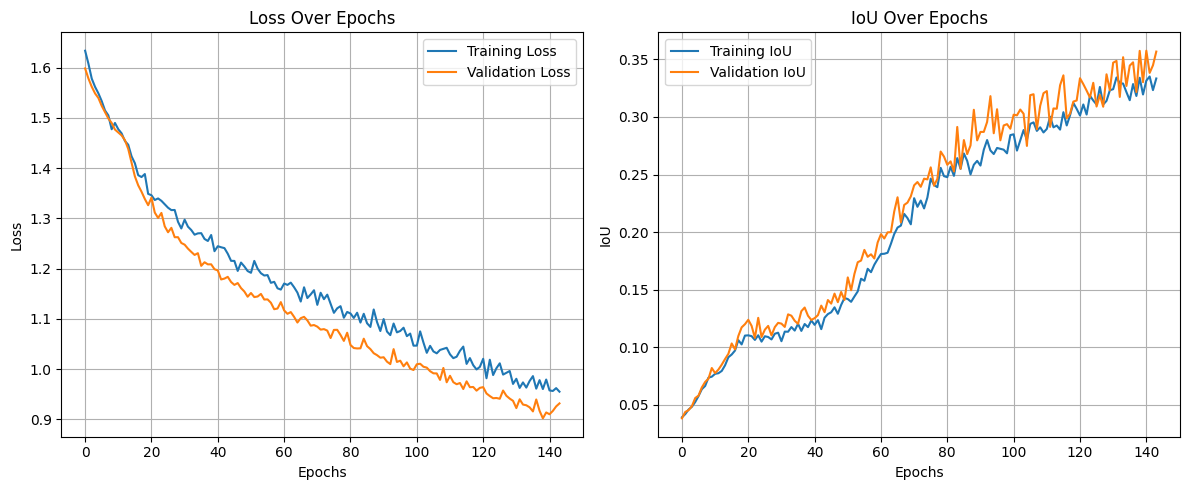

In [18]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Convert GPU tensors to CPU for plotting (to avoid errors)
train_loss = [x.cpu().item() if torch.is_tensor(x) else x for x in history['train_loss']]
val_loss = [x.cpu().item() if torch.is_tensor(x) else x for x in history['val_loss']]
train_metrics = [x.cpu().item() if torch.is_tensor(x) else x for x in history['train_metrics']]
val_metrics = [x.cpu().item() if torch.is_tensor(x) else x for x in history['val_metrics']]

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(train_metrics, label='Training IoU')
plt.plot(val_metrics, label='Validation IoU')
plt.title('IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

At 140 epochs, the model seems to be approximately converging to the best possible performance with the chosen hyperparameters.